In [1]:
import os
from importlib.resources import files
import time

import copy
import numpy as np
import torch

%matplotlib widget
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from learn_embedding.approximators import *
from learn_embedding.covariances import *
from learn_embedding.kernels import SquaredExp
from learn_embedding.embedding import Embedding
from learn_embedding.dynamics import FirstGeometry, SecondGeometry, LinearField
from learn_embedding.utils import *
from learn_embedding.loss import *

## Load Dataset

In [2]:
dim = 2
num_traj = 7  # Total number of trajectories
num_train = 3 # Number of trajectories used for training
num_samples = 1000  # Desired number of samples per trajectory

train_x = np.empty((0, 4))
train_y = np.empty((0, 2))
test_x = np.empty((0, 4))
test_y = np.empty((0, 2))

for i in range(1, num_traj + 1):
    # Load trajectory data
    data = np.loadtxt("../learn_embedding/data/toycase/trajectory_" + str(i) + ".csv")
    
    # remove last point
    data = data[:-1,:]
    
    # subsample
    idx = DataProcess.subsample(data[:,:2], num_samples)
    
    # center
    data[idx,:2] -= data[-1,:2]
    
    # zero velocity last sample
    data[-1,2:4] = np.zeros(2)
    
    # zero acceleration last sample
    data[-1,-2:] = np.zeros(2)
    
    # add to datset
    if i <= num_train:
        train_x = np.append(train_x, data[idx,:4], axis=0)
        train_y = np.append(train_y, data[idx,-2:], axis=0)
    else:
        test_x = np.append(test_x, data[idx,:4], axis=0)
        test_y = np.append(test_y, data[idx,-2:], axis=0)

## Torch Configuration

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

train_x = torch.from_numpy(train_x).float().contiguous().requires_grad_(True).to(device)
train_y = torch.from_numpy(train_y).float().contiguous().to(device)
test_x = torch.from_numpy(test_x).float().contiguous().requires_grad_(True).to(device)
test_y = torch.from_numpy(test_y).float().requires_grad_(True).to(device)

## Create Model

In [4]:
model_first = FirstGeometry(
    Embedding(FeedForward(dim, [64]*2, 1)), 
    torch.tensor([0.0,0.0]).to(device), 
    SPD(dim) # Spherical()
).to(device)

TorchHelper.load(model_first,'../outputs/synthetic_1')

In [5]:
torch.manual_seed(1337)

# approximator = KernelExpansion(train_x[:, :dim])
# approximator = KernelMachine(dim, 1000, 1, length=0.4)

num_neurons = [64]
num_layers = 2
approximator = FeedForward(dim, num_neurons*num_layers, 1)

embedding = copy.deepcopy(model_first.embedding)
# TorchHelper.set_grad(embedding, False)
# embedding = Embedding(approximator)
# TorchHelper.set_zero(embedding)

stiffness = SPD(dim)
# stiffness = copy.deepcopy(model_first.stiffness)
# stiffness = Spherical(eval=0.0,grad=False)

dissipation = SPD(dim)
# dissipation.eigvec.data = torch.tensor([1.0, 0.0]).to(device)
# dissipation.eigval.data = torch.tensor([2.0, 0.0]).to(device) 
# dissipation = copy.deepcopy(stiffness)
# dissipation = copy.deepcopy(model_first.stiffness)
# dissipation = Spherical(eval=20.0,grad=False)
# dissipation.eigval.data *= 2

attractor = train_x[-1][:2].detach()

field = LinearField(attractor, Spherical(1.0, True))
field_weight = 20.0

model = SecondGeometry(embedding, attractor, stiffness, dissipation).to(device)
TorchHelper.load(model, '../outputs/synthetic_2')
TorchHelper.set_grad(model_first, False)

In [6]:
# # directional dissipation
# model.field = model_first # delattr(model, 'field')
# model.field_weight = field_weight

# # exponential dissipation
# model.exp_dissipation = SquaredExp(l=0.1)
# model.exp_dissipation_weight = 1.0

## Train

## Plot

In [7]:
resolution = 100
std = train_x.detach().std(axis=0)
min_ax = train_x.detach().min(axis=0)[0] - std/2
max_ax = train_x.detach().max(axis=0)[0] + std/2
# min_ax = torch.tensor([-1.0, -1.0]).to(device)
# max_ax = torch.tensor([1.0, 1.0]).to(device)
x, y = torch.meshgrid(torch.linspace(min_ax[0], max_ax[0], resolution), torch.linspace(min_ax[1], max_ax[1], resolution), indexing='xy')

grid_x = torch.stack((torch.ravel(x), torch.ravel(y)), dim=1).to(device).requires_grad_(True)
grid_v = torch.zeros_like(grid_x).to(device).requires_grad_(True)

grid_xr = torch.stack((torch.ravel(x[10::10,10::10]), torch.ravel(y[10::10,10::10])), dim=1).to(device).requires_grad_(True)
grid_vr = torch.zeros_like(grid_xr).to(device).requires_grad_(True)

theta = torch.linspace(0, 2*torch.pi, steps=50).to(device)

### GMM

In [8]:
from learn_embedding.utils.gmm import GaussianMixture

n_components = 3
gmm = GaussianMixture(n_components, dim, covariance_type="full").to(device)
gmm.fit(torch.cat([train_x[:,:2], test_x[:,:2]],dim=0)) # think about having gmm in 4 dimension to include velocities as well
prob = gmm.score_samples(grid_x).reshape(resolution, -1).exp().cpu().detach().numpy()

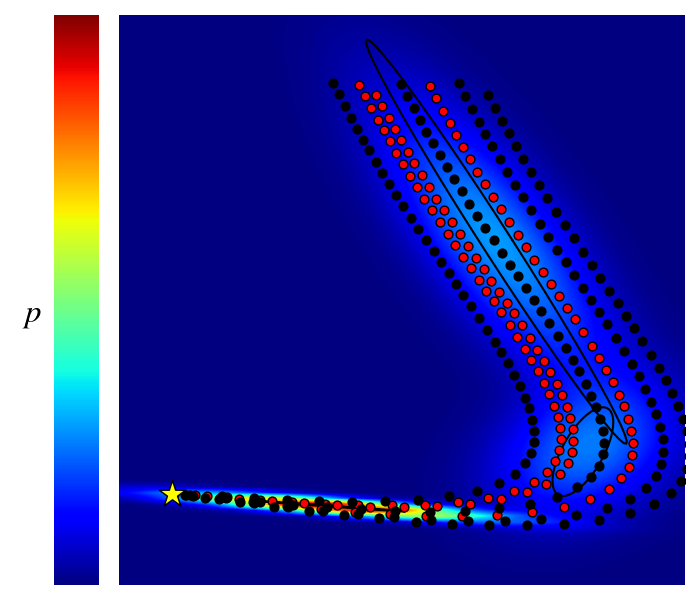

In [9]:
# Enable LaTeX rendering
plt.rcParams['text.usetex'] = True

# Set Times as the font family
plt.rcParams['font.family'] = 'Times'

fig, ax = plt.subplots(figsize=(7, 6))

steps = 20
im = ax.contourf(x, y, prob, 500, cmap="jet")
# ax.contour(x, y, prob, 10, cmap=None, colors='#f2e68f')
ax.scatter(train_x.cpu().detach()[::steps, 0], train_x.cpu().detach()[::steps, 1], s=40, edgecolors='k', c='red', zorder=10)
ax.scatter(test_x.cpu().detach()[::steps, 0], test_x.cpu().detach()[::steps, 1], s=40, edgecolors='k', c='black', zorder=10)
ax.scatter(attractor[0].cpu(), attractor[1].cpu(), s=400, edgecolors='k', c='yellow', marker="*", zorder=20)

for i in range(n_components):
    center = gmm.mu[0][i].detach().cpu()
    evals, evecs = torch.linalg.eigh(gmm.var[0][i])
    evals *= 10
    mixture_ellipse = torch.stack((evals[0]*theta.cos(), evals[1]*theta.sin()), dim=1)
    mixture_ellipse = torch.mm(evecs, mixture_ellipse.T).T.detach().cpu() + center
    ax.plot(mixture_ellipse[:,0], mixture_ellipse[:,1], c='k')

divider = make_axes_locatable(ax)
cax = divider.append_axes("left", size="8%", pad=0.2)
cax.yaxis.set_label_position("left")
norm = plt.Normalize(vmin=prob.min(), vmax=prob.max())
colors = plt.cm.jet(norm(prob))
mappable = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=norm)
cbar = fig.colorbar(mappable, cax=cax)
cbar.outline.set_visible(False)
cbar.ax.tick_params(size=0)
cbar.set_ticks([])
cbar.set_label('$p$', fontsize=24, rotation=0, labelpad=-50)

ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xticks([])
ax.set_yticks([])

ax.set_xlim([min_ax[0].cpu(), max_ax[0].cpu()])
ax.set_ylim([min_ax[1].cpu(), max_ax[1].cpu()])

# Adjust layout
fig.tight_layout()

### Potential

In [10]:
potential = model.potential(grid_x).reshape(resolution, -1).cpu().detach().numpy()

if stiffness.__class__.__name__ == 'SPD':
    evals = stiffness.eigval.data.exp()
elif stiffness.__class__.__name__ == 'Diagonal':
    evals = stiffness.diagonal.data.exp()
elif stiffness.__class__.__name__ == 'Spherical':
    evals = stiffness.eval.data.exp().repeat(dim)
evecs = stiffness.eigvec.data if stiffness.__class__.__name__ == 'SPD' else torch.tensor([1.0, 0.0]).to(device)
U, _ = torch.linalg.qr(torch.cat((evecs.unsqueeze(1), torch.rand(evecs.shape[0], evecs.shape[0]-1).to(device)), dim=1))
stiffness_ellipse = torch.stack((evals[0]*theta.cos(), evals[1]*theta.sin()), dim=1)
stiffness_ellipse = torch.mm(U, stiffness_ellipse.T).T.detach().cpu()/50
print("Stiffness Evals: ", evals)
print("Stiffness Evecs: ", evecs)


if dissipation.__class__.__name__ == 'SPD':
    evals = dissipation.eigval.data.exp()
elif dissipation.__class__.__name__ == 'Diagonal':
    evals = dissipation.diagonal.data.exp()
elif dissipation.__class__.__name__ == 'Spherical':
    evals = dissipation.eval.data.exp().repeat(dim)
evecs = dissipation.eigvec.data if dissipation.__class__.__name__ == 'SPD' else torch.tensor([1.0, 0.0]).to(device)
U, _ = torch.linalg.qr(torch.cat((evecs.unsqueeze(1), torch.rand(evecs.shape[0], evecs.shape[0]-1).to(device)), dim=1))
dissipation_ellipse = torch.stack((evals[0]*theta.cos(), evals[1]*theta.sin()), dim=1)
dissipation_ellipse = torch.mm(U, dissipation_ellipse.T).T.detach().cpu()/50
print("Dissipation Evals: ", evals)
print("Dissipation Evecs: ", evecs)

Stiffness Evals:  tensor([0.3743, 4.0253], device='cuda:0')
Stiffness Evecs:  tensor([ 0.8857, -0.1312], device='cuda:0')
Dissipation Evals:  tensor([0.7200, 4.4144], device='cuda:0')
Dissipation Evecs:  tensor([1.2707, 0.1017], device='cuda:0')


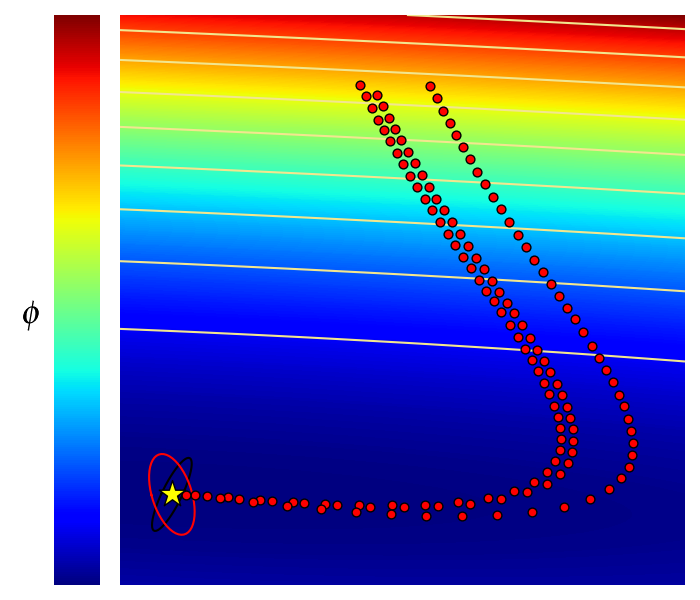

In [11]:
# Enable LaTeX rendering
plt.rcParams['text.usetex'] = True

# Set Times as the font family
plt.rcParams['font.family'] = 'Times'

fig, ax = plt.subplots(figsize=(7, 6))

steps = 20
im = ax.contourf(x, y, potential, 500, cmap="jet")
ax.contour(x, y, potential, 10, cmap=None, colors='#f2e68f')
ax.scatter(train_x.cpu().detach()[::steps, 0], train_x.cpu().detach()[::steps, 1], s=40, edgecolors='k', c='red', zorder=10)
ax.scatter(attractor[0].cpu(), attractor[1].cpu(), s=400, edgecolors='k', c='yellow', marker="*", zorder=20)
ax.plot(stiffness_ellipse[:,0], stiffness_ellipse[:,1], c='k')
ax.plot(dissipation_ellipse[:,0], dissipation_ellipse[:,1], c='r')

divider = make_axes_locatable(ax)
cax = divider.append_axes("left", size="8%", pad=0.2)
cax.yaxis.set_label_position("left")
norm = plt.Normalize(vmin=potential.min(), vmax=potential.max())
colors = plt.cm.jet(norm(potential))
mappable = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=norm)
cbar = fig.colorbar(mappable, cax=cax)
cbar.outline.set_visible(False)
cbar.ax.tick_params(size=0)
cbar.set_ticks([])
cbar.set_label('$\phi$', fontsize=24, rotation=0, labelpad=-50)

ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

# ax.set_xlabel('$q_1$', fontsize=24)
# ax.set_ylabel('$q_2$', fontsize=24, rotation=0, labelpad=20)
# ax.axis('equal')

ax.set_xticks([])
ax.set_yticks([])

# Adjust layout
fig.tight_layout()

fig.savefig('../outputs/synthetic_potential_second.png', format='png', dpi=300, bbox_inches="tight")

### Vector Field & Streamlines

In [12]:
# directional dissipation
model.field = model_first # delattr(model, 'field')
model.field_weight = 20.0

# exponential dissipation
model.exp_dissipation = SquaredExp(l=0.1)
model.exp_dissipation_weight = 50.0

In [13]:
obstacle_radius = 0.07 # 0.05 , 0.1
obstacle = torch.tensor([[0.25,0.4]])
# obstacle = Obstacles.square(center=torch.tensor([-30,20]), a=20, b=20, res=10)
# obstacle = Obstacles.semi_circle(radius=0.2, center=torch.tensor([-0.4,   -0.4]), rot=torch.tensor(torch.pi/4), res=50)
decay = 1e-1
lengthscale = np.sqrt(-0.5*obstacle_radius**2/np.log(decay))
# phi = KernelExpansion(obstacle.to(device), kernel=SquaredExp(l=lengthscale)).to(device) 
# embedding.local_deformation = KernelDeformation(obstacle.to(device), weights=1.5*torch.ones(obstacle.shape[0]).to(device), kernel=SquaredExp(l=lengthscale), tol=-0.05).to(device)
# model.velocity_embedding = True


field = model(torch.cat((grid_x,grid_v),dim=1))
x_field = field[:, 0].reshape(resolution, -1).cpu().detach().numpy()
y_field = field[:, 1].reshape(resolution, -1).cpu().detach().numpy()

# # x0 = TorchHelper.grid_uniform(center=train_x[0,:].detach(), length=0.01, samples=3).to(device).requires_grad_(True)
# x0 = TorchHelper.grid_uniform(center=train_x[0,:].detach(), la=0.1, lb=0.01, samples=5).to(device).requires_grad_(True)
# v0 = torch.zeros_like(x0).to(device).requires_grad_(True)
# streamlines = Integrator.second_order(dynamics=model,x0=torch.cat((x0,v0),dim=1),T=6.5, dt=0.01).cpu().detach().numpy()

x0 = np.empty((0, 4))
for i in range(num_train + 1, num_traj + 1):
    data = np.loadtxt("../learn_embedding/data/toycase/trajectory_" + str(i) + ".csv")
    data[:,:2] -= data[-1,:2]
    x0 = np.append(x0, data[0,:4][np.newaxis, :], axis=0)
x0 = torch.from_numpy(x0).float().to(device).requires_grad_(True)
x0.data[0,2] = 1.0
streamlines = Integrator.second_order(dynamics=model,x0=x0,T=10.0, dt=0.01).cpu().detach().numpy()

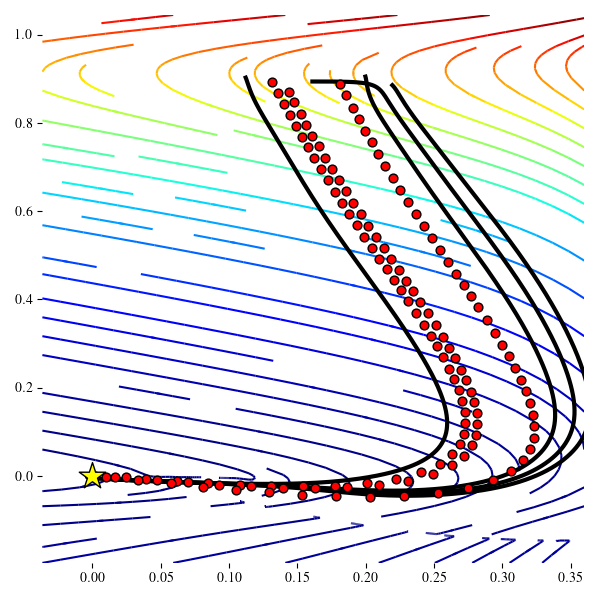

In [14]:
# Enable LaTeX rendering
plt.rcParams['text.usetex'] = True

# Set Times as the font family
plt.rcParams['font.family'] = 'Times'

fig, ax = plt.subplots(figsize=(6, 6))

steps = 20
ax.streamplot(x.numpy(), y.numpy(), x_field, y_field, color=potential, cmap="jet", linewidth=1.5, arrowstyle='-', arrowsize=1.5)
ax.scatter(train_x.cpu().detach()[::steps, 0], train_x.cpu().detach()[::steps, 1], s=40, edgecolors='k', c='red', zorder=10)
ax.scatter(attractor[0].cpu(), attractor[1].cpu(), s=400, edgecolors='k', c='yellow', marker="*", zorder=10)

for i in range(streamlines.shape[1]):
    ax.plot(streamlines[:, i, 0], streamlines[:, i, 1], color='k', linewidth=3.0)
    
if hasattr(embedding, 'local_deformation'):
    for i in range(0,obstacle.shape[0],4):
        circ = plt.Circle((obstacle[i, 0], obstacle[i, 1]), obstacle_radius-0.04,
                            color='k', fill='grey', alpha=0.5)
        ax.add_patch(circ)
# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="8%", pad=0.2)
# cax.yaxis.set_label_position("right")
# norm = plt.Normalize(vmin=potential.min(), vmax=potential.max())
# colors = plt.cm.jet(norm(potential))
# mappable = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=norm)
# cbar = fig.colorbar(mappable, cax=cax)
# cbar.outline.set_visible(False)
# cbar.ax.tick_params(size=0)
# cbar.set_ticks([])
# cbar.set_label('$\phi$', fontsize=24, rotation=0, labelpad=20)

ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

# ax.set_xlabel('$q_1$', fontsize=24)
# ax.set_ylabel('$q_2$', fontsize=24, rotation=0, labelpad=20)

# ax.set_xticks([])
# ax.set_yticks([])

ax.set_xlim([min_ax[0].cpu(), max_ax[0].cpu()])
ax.set_ylim([min_ax[1].cpu(), max_ax[1].cpu()])

# Adjust layout
fig.tight_layout()
fig.savefig('../outputs/synthetic_field_second.png', format='png', dpi=300, bbox_inches="tight")

### Embedding

In [15]:
import faiss
import faiss.contrib.torch_utils

if use_cuda:
    res = faiss.StandardGpuResources()
    knn = faiss.GpuIndexIVFFlat(res, dim, 1, faiss.METRIC_L2) # as for gmm think about knn in phase space
else:
    knn = faiss.IndexFlatL2(dim)
    
knn.train(train_x[:,:2].contiguous())
knn.add(train_x[:,:2].contiguous())

dist = knn.search(grid_x, 1)[0].sqrt().squeeze()

rad = torch.tensor(0.5).to(device)
beta = torch.tensor(1.0).to(device)

bump = torch.zeros_like(dist)
bump[dist.abs() < rad] = dist[dist.abs() < rad].square().sub(rad.square()).pow(-1).mul(beta).exp().div(rad.square().pow(-1).mul(-beta).exp())

/home/bernardo/.local/lib/python3.10/site-packages/faiss/contrib/torch_utils.py:51: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  x.storage().data_ptr() + x.storage_offset() * 4)


In [16]:
grid_embedding = embedding(grid_x)
x_embedding = grid_embedding[:, 0].reshape(resolution, -1).cpu().detach().numpy()
y_embedding = grid_embedding[:, 1].reshape(resolution, -1).cpu().detach().numpy()
z_embedding = (grid_embedding[:, 2]).reshape(resolution, -1).cpu().detach().numpy()
train_embedding = embedding(train_x[:,:dim]).cpu().detach().numpy()

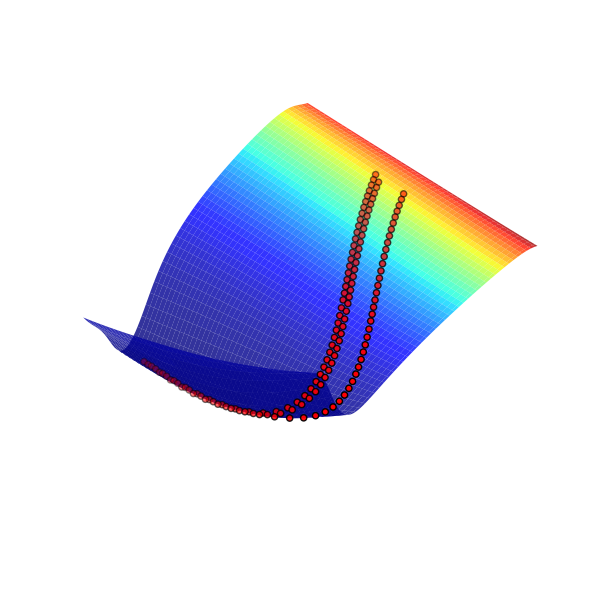

In [17]:
# Enable LaTeX rendering
plt.rcParams['text.usetex'] = True

# Set Times as the font family
plt.rcParams['font.family'] = 'Times'

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection="3d", computed_zorder=False)

steps = 20
norm = plt.Normalize(vmin=potential.min(), vmax=potential.max())
colors = plt.cm.jet(norm(potential))

im = ax.plot_surface(x_embedding, y_embedding, z_embedding, cmap='jet', edgecolor='none', antialiased=True, alpha=0.8, facecolors=colors)
ax.scatter(train_embedding[::steps, 0], train_embedding[::steps, 1], train_embedding[::steps, 2], s=20, edgecolors='k', c='red', zorder=10)

ax.set_xlabel('$y^1$')
ax.set_ylabel('$y^2$')
ax.set_zlabel('$y^3$')

# Adjust plot limits, if necessary
# ax.set_xlim(x_min, x_max)
# ax.set_ylim(y_min, y_max)
# ax.set_zlim(z_min, z_max)

ax.axis('off')

ax.view_init(elev=45, azim=-45)  # Adjust the elevation (up/down) and azimuth (left/right) an

# # Add colorbar without ticks and labels
# mappable = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=norm)
# cbar = fig.colorbar(mappable, ax=ax, shrink=0.5, aspect=10)
# cbar.set_label('$\phi$', fontsize=24, rotation=0, labelpad=10)

# cbar.ax.set_yticklabels([])
# cbar.ax.tick_params(length=0)
# cbar.outline.set_visible(False)  # Remove colorbar frame

# # Shrink colorbar to dimensions of the plot
# cbar.ax.set_position([0.52, 0.1, 0.03, 0.8])  # Adjust colorbar position and width

# Adjust layout
fig.tight_layout()
fig.savefig('../outputs/synthetic_embedding_second.png', format='png', dpi=300, bbox_inches="tight")

### Metric

In [18]:
metric = model.embedding.pullmetric(grid_embedding, model.embedding.jacobian(grid_x, grid_embedding))
det_metric = metric.det().reshape(resolution, -1).detach().cpu().numpy()

red_embedding = embedding(grid_xr)
metric_r = embedding.pullmetric(red_embedding, embedding.jacobian(grid_xr, red_embedding))
evals,evecs = torch.linalg.eigh(metric_r)
evals /= torch.tensor([100,10000]).to(device)

ellipses = torch.stack((evals[:, 0].unsqueeze(-1)*theta.cos(), evals[:, 1].unsqueeze(-1)*theta.sin()), dim=2)
ellipses = torch.bmm(evecs, ellipses.permute(0, 2, 1)).permute(0, 2, 1).detach().cpu()
ellipses_x = x[10::10,10::10].ravel().unsqueeze(-1) + ellipses[:, :, 0]
ellipses_y = y[10::10,10::10].ravel().unsqueeze(-1) + ellipses[:, :, 1]

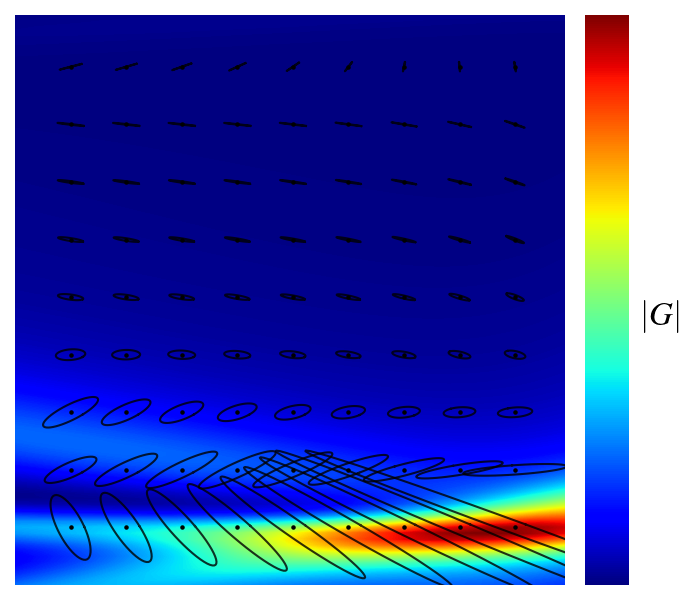

In [19]:
# Enable LaTeX rendering
plt.rcParams['text.usetex'] = True

# Set Times as the font family
plt.rcParams['font.family'] = 'Times'

# Create the figure and axes
fig, ax = plt.subplots(figsize=(7, 6))

# Plot the filled contour
contour = ax.contourf(x, y, det_metric, 500, cmap="jet")

# Plot scattered points
ax.scatter(x[10::10, 10::10], y[10::10, 10::10], color="k", s=5)

# Plot ellipses
for i in range(ellipses.shape[0]):
    ax.plot(ellipses_x[i, :], ellipses_y[i, :], color="k", linewidth=1.5, alpha=0.8)

# Add colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="8%", pad=0.2)
cax.yaxis.set_label_position("right")
norm = plt.Normalize(vmin=det_metric.min(), vmax=det_metric.max())
colors = plt.cm.jet(norm(det_metric))
mappable = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=norm)
cbar = fig.colorbar(mappable, cax=cax)
cbar.outline.set_visible(False)
cbar.ax.tick_params(size=0)
cbar.set_ticks([])
cbar.set_label(r'$|G|$', fontsize=24, rotation=0, labelpad=25)

# Set labels and tick sizes
# ax.set_xlabel('$q_1$', fontsize=24)
# ax.set_ylabel('$q_2$', fontsize=24, rotation=0, labelpad=20)
# ax.tick_params(axis='both', which='major', labelsize=16)

# Set axis limits
ax.set_xlim([min_ax[0].cpu(), max_ax[0].cpu()])
ax.set_ylim([min_ax[1].cpu(), max_ax[1].cpu()])

# Hide spines
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

# Remove ticks
ax.set_xticks([])
ax.set_yticks([])

# Improve plot layout
fig.tight_layout()

# Adjust layout
fig.tight_layout()
fig.savefig('../outputs/synthetic_detmetric_second.png', format='png', dpi=300, bbox_inches="tight")

### Inverse Metric Ellispses on Streamlines

In [20]:
eval_scale = 10
x_sampled = torch.from_numpy(streamlines[:, 0, :dim]).float().to(device).requires_grad_(True)
v_sampled = torch.from_numpy(streamlines[:, 0, dim:]).float().to(device).requires_grad_(True)
sampled_embedding = embedding(x_sampled)

metric_sampled = model.embedding.pullmetric(sampled_embedding, model.embedding.jacobian(x_sampled, sampled_embedding))
metric_evals,metric_evecs = torch.linalg.eigh(metric_sampled.inverse())
metric_evals/= torch.tensor([100,100]).to(device)

metric_ellipses = torch.stack((metric_evals[:, 0].unsqueeze(-1)*theta.cos(), metric_evals[:, 1].unsqueeze(-1)*theta.sin()), dim=2)
metric_ellipses = torch.bmm(metric_evecs, metric_ellipses.permute(0, 2, 1)).permute(0, 2, 1).detach().cpu()

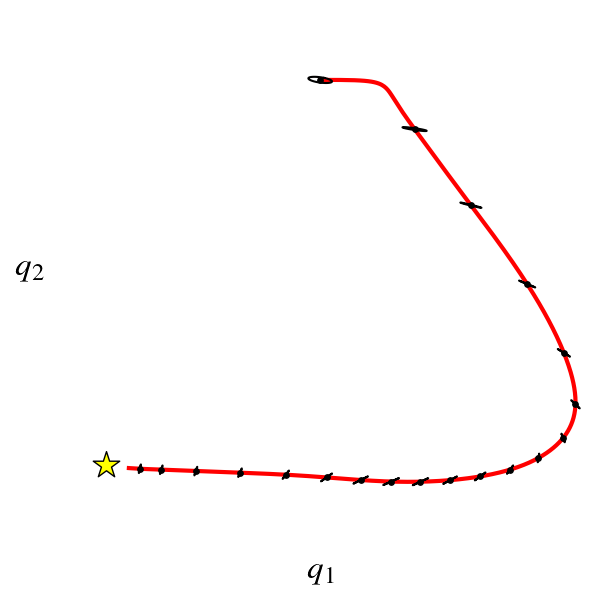

In [21]:
# Enable LaTeX rendering
plt.rcParams['text.usetex'] = True

# Set Times as the font family
plt.rcParams['font.family'] = 'Times'

fig, ax = plt.subplots(figsize=(6, 6))

step = 50
ax.plot(x_sampled[:, 0].detach().cpu(), x_sampled[:, 1].detach().cpu(), color='r', linewidth='3')

ax.scatter(x_sampled[::step, 0].detach().cpu(), x_sampled[::step, 1].detach().cpu(), color="k", s=15, zorder=10)

for i in range(0, metric_ellipses.shape[0], step):
    ax.plot(x_sampled[i, 0].detach().cpu() + metric_ellipses[i, :, 0],
            x_sampled[i, 1].detach().cpu() + metric_ellipses[i, :, 1], color="k", linewidth=1.5)
    
ax.scatter(attractor[0].cpu(), attractor[1].cpu(), s=400, edgecolors='k', c='yellow', marker="*", zorder=20)

# Set labels and tick sizes
ax.set_xlabel('$q_1$', fontsize=24)
ax.set_ylabel('$q_2$', fontsize=24, rotation=0, labelpad=20)
# ax.tick_params(axis='both', which='major', labelsize=16)

# Set axis limits
ax.set_xlim([min_ax[0].cpu(), max_ax[0].cpu()])
ax.set_ylim([min_ax[1].cpu(), max_ax[1].cpu()])

# Hide spines
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

# Remove ticks
ax.set_xticks([])
ax.set_yticks([])

# Improve plot layout
fig.tight_layout()

fig.savefig('../outputs/synthetic_metric_second.png', format='png', dpi=300, bbox_inches="tight")

### Christoffel Symbols Ellispses on Streamlines

In [22]:
christoffel_sampled = embedding.christoffel(x_sampled, metric_sampled)
christoffel_sampled = torch.einsum('bqij,bi->bqj', christoffel_sampled, v_sampled)
christoffel_evals,christoffel_evecs = torch.linalg.eig(christoffel_sampled)
christoffel_evals = torch.real(christoffel_evals)
christoffel_evecs = torch.real(christoffel_evecs)
christoffel_evals/= torch.tensor([20,0.000001]).to(device)

christoffel_ellipses = torch.stack((christoffel_evals[:, 0].unsqueeze(-1)*theta.cos(), christoffel_evals[:, 1].unsqueeze(-1)*theta.sin()), dim=2)
christoffel_ellipses = torch.bmm(christoffel_evecs, christoffel_ellipses.permute(0, 2, 1)).permute(0, 2, 1).detach().cpu()

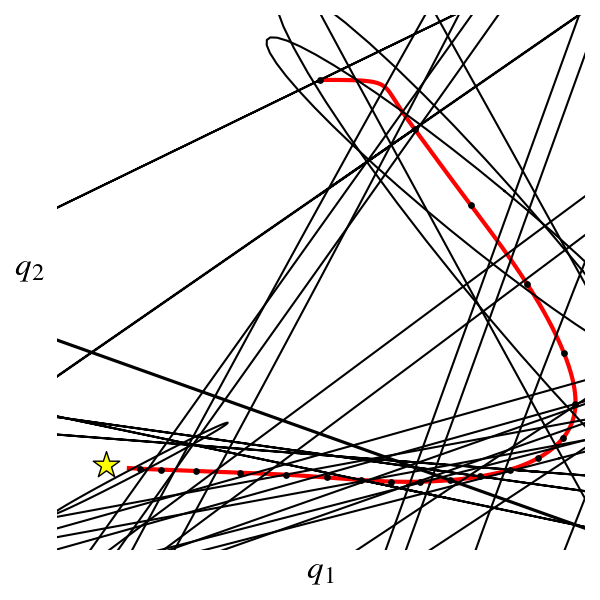

In [23]:
# Enable LaTeX rendering
plt.rcParams['text.usetex'] = True

# Set Times as the font family
plt.rcParams['font.family'] = 'Times'

fig, ax = plt.subplots(figsize=(6, 6))

step = 50
ax.plot(x_sampled[:, 0].detach().cpu(), x_sampled[:, 1].detach().cpu(), color='r', linewidth='3')

ax.scatter(x_sampled[::step, 0].detach().cpu(), x_sampled[::step, 1].detach().cpu(), color="k", s=15, zorder=10)

for i in range(0,christoffel_ellipses.shape[0],step):
    ax.plot(x_sampled[i, 0].detach().cpu() + christoffel_ellipses[i, :, 0],
            x_sampled[i, 1].detach().cpu() + christoffel_ellipses[i, :, 1], color="k", linewidth=1.5)
    
ax.scatter(attractor[0].cpu(), attractor[1].cpu(), s=400, edgecolors='k', c='yellow', marker="*", zorder=20)

if hasattr(embedding, 'local_deformation'):
    for i in range(obstacle.shape[0]):
        circ = plt.Circle((obstacle[i, 0], obstacle[i, 1]), obstacle_radius,
                            color='k', fill='grey', alpha=0.5)
        ax.add_patch(circ)
        
# Set labels and tick sizes
ax.set_xlabel('$q_1$', fontsize=24)
ax.set_ylabel('$q_2$', fontsize=24, rotation=0, labelpad=20)
# ax.tick_params(axis='both', which='major', labelsize=16)

# Set axis limits
ax.set_xlim([min_ax[0].cpu(), max_ax[0].cpu()])
ax.set_ylim([min_ax[1].cpu(), max_ax[1].cpu()])

# Hide spines
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

# Remove ticks
ax.set_xticks([])
ax.set_yticks([])

# Improve plot layout
fig.tight_layout()

fig.savefig('../outputs/synthetic_christoffel_second.png', format='png', dpi=300, bbox_inches="tight")